In [265]:
import pandas as pd  # linear algebra
import numpy as np  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # visuals
import seaborn as sns  # visuals
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

#.drop(['family', 'id', 'store_nbr', 'onpromotion'], axis=1)
train = pd.read_csv('train.csv', parse_dates=['date'], infer_datetime_format=True)

test = pd.read_csv('test.csv')



# importing additional data
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
#transactions = pd.read_csv('transactions.csv')
holidays = pd.read_csv('holidays_events.csv')

train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [266]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [267]:
# breaking the set down into numeric and categorical values
df_num = train[['id', 'store_nbr', 'sales', 'onpromotion']]
df_cat = train[['date', 'family']]

In [268]:
sales = train.copy()
sales = sales.set_index('date').to_period('D')
#sales = sales.set_index(['store_nbr','family'], append = True)

sales

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [269]:
avg_sales = sales.groupby('date').mean()
# ['sales']
avg_sales.head()

,id,store_nbr,sales,onpromotion
date,,,,
2013-01-01,890.5,27.5,1.409438,0.0
2013-01-02,2672.5,27.5,278.390807,0.0
2013-01-03,4454.5,27.5,202.840197,0.0
2013-01-04,6236.5,27.5,198.911154,0.0
2013-01-05,8018.5,27.5,267.873244,0.0


In [270]:
avg_sales['time'] = np.arange(len(avg_sales.index))
avg_sales

,id,store_nbr,sales,onpromotion,time
date,,,,,
2013-01-01,890.5,27.5,1.409438,0.000000,0
2013-01-02,2672.5,27.5,278.390807,0.000000,1
2013-01-03,4454.5,27.5,202.840197,0.000000,2
2013-01-04,6236.5,27.5,198.911154,0.000000,3
2013-01-05,8018.5,27.5,267.873244,0.000000,4
...,...,...,...,...,...
2017-08-11,2992868.5,27.5,463.733851,7.956790,1679
2017-08-12,2994650.5,27.5,444.798280,4.664422,1680
2017-08-13,2996432.5,27.5,485.768618,5.209315,1681


In [271]:
from sklearn.linear_model import LinearRegression

# Training data

#X = avg_sales.drop_index(['family', 'store_nbr'], axis=0) 
X = avg_sales.loc[:, ['time']]
X.dropna(inplace=True)  # drop missing values in the feature set

y = avg_sales.loc[:, 'sales']  # target
#y, X = y.align(X, join='inner')  # drop corresponding values in target
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


Text(0.5, 1.0, 'Time Plot of Sales')

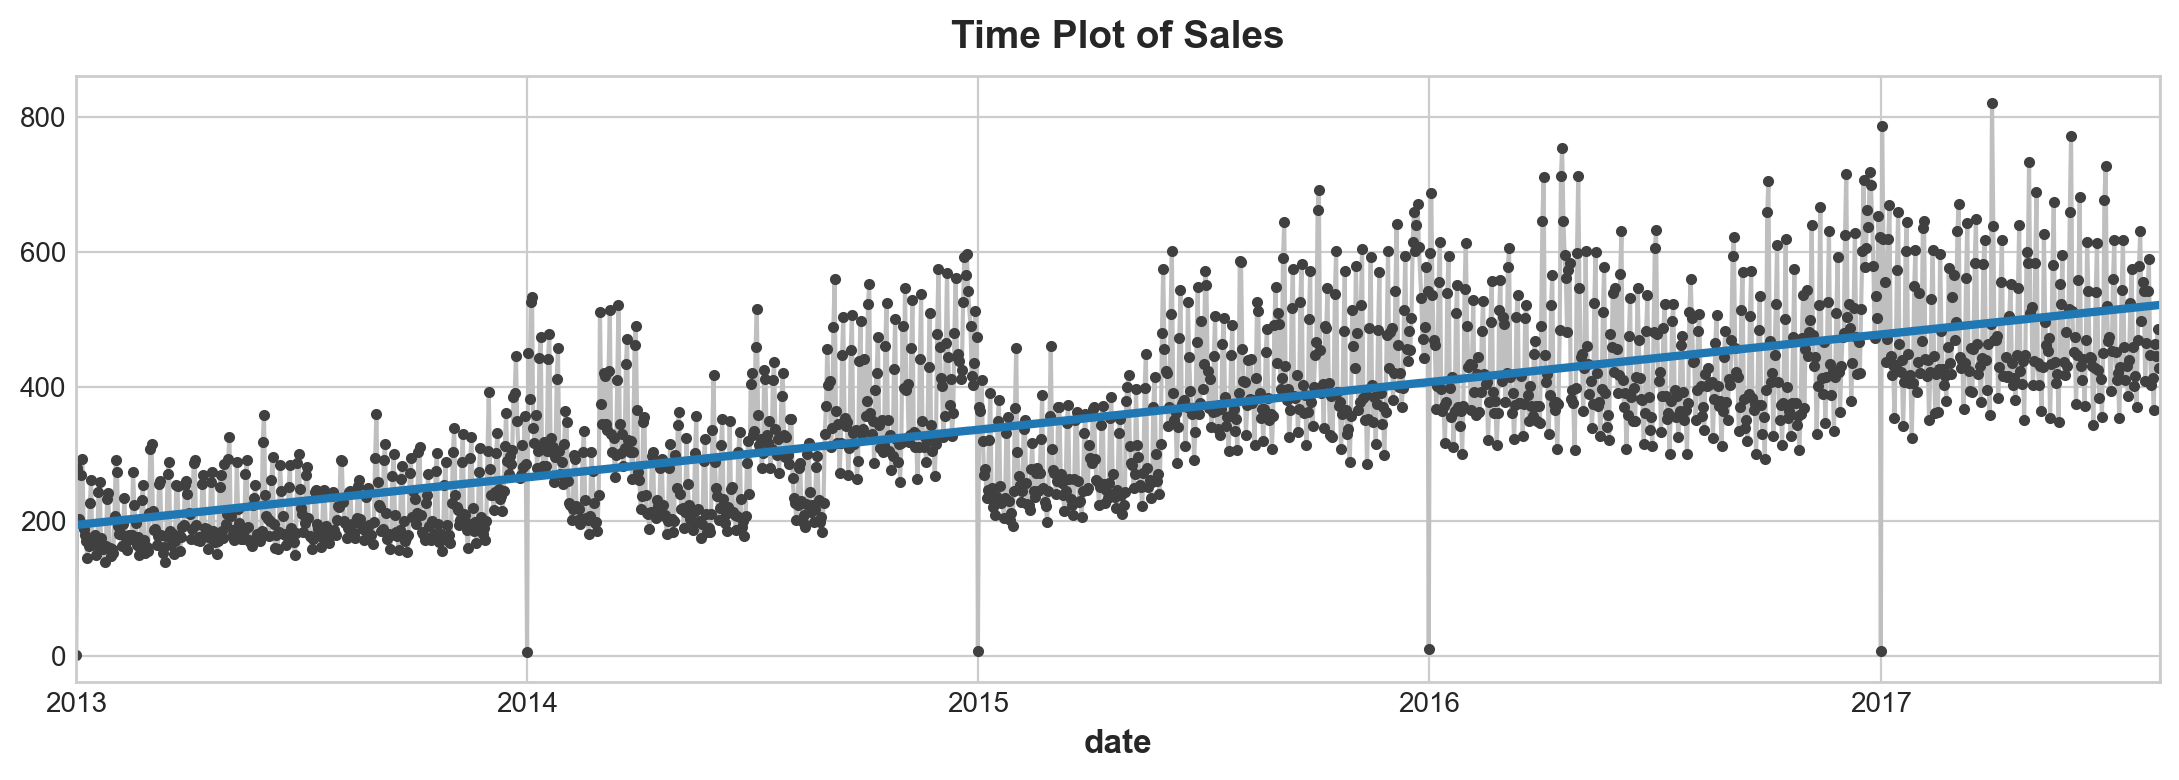

In [272]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Sales')


In [273]:
#lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.
avg_sales['lag_1'] = avg_sales['sales'].shift(1)
avg_sales = avg_sales.reindex(columns=['sales', 'lag_1'])
avg_sales.head()



,sales,lag_1
date,,
2013-01-01,1.409438,NaN
2013-01-02,278.390807,1.409438
2013-01-03,202.840197,278.390807
2013-01-04,198.911154,202.840197
2013-01-05,267.873244,198.911154


Text(0.5, 1.0, 'Lag Plot of Sales')

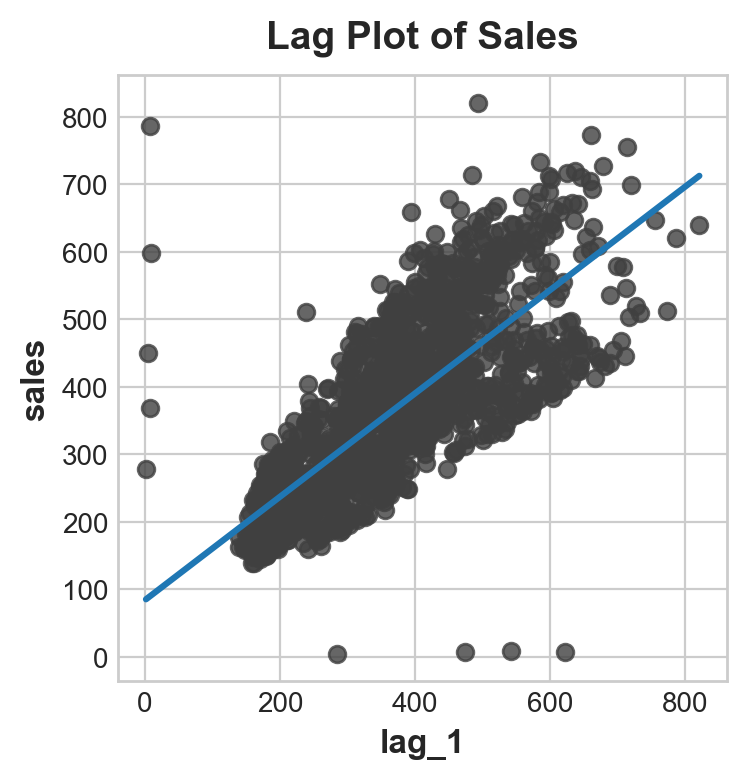

In [274]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='sales', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Sales')


In [275]:
'''
avg_sales = avg_sales.drop(columns=['store_nbr', 'id', 'onpromotion', 'time'])
avg_sales.columns
'''


"\navg_sales = avg_sales.drop(columns=['store_nbr', 'id', 'onpromotion', 'time'])\navg_sales.columns\n"

<AxesSubplot: title={'center': '365-Day Moving Average of Sales '}, xlabel='date'>

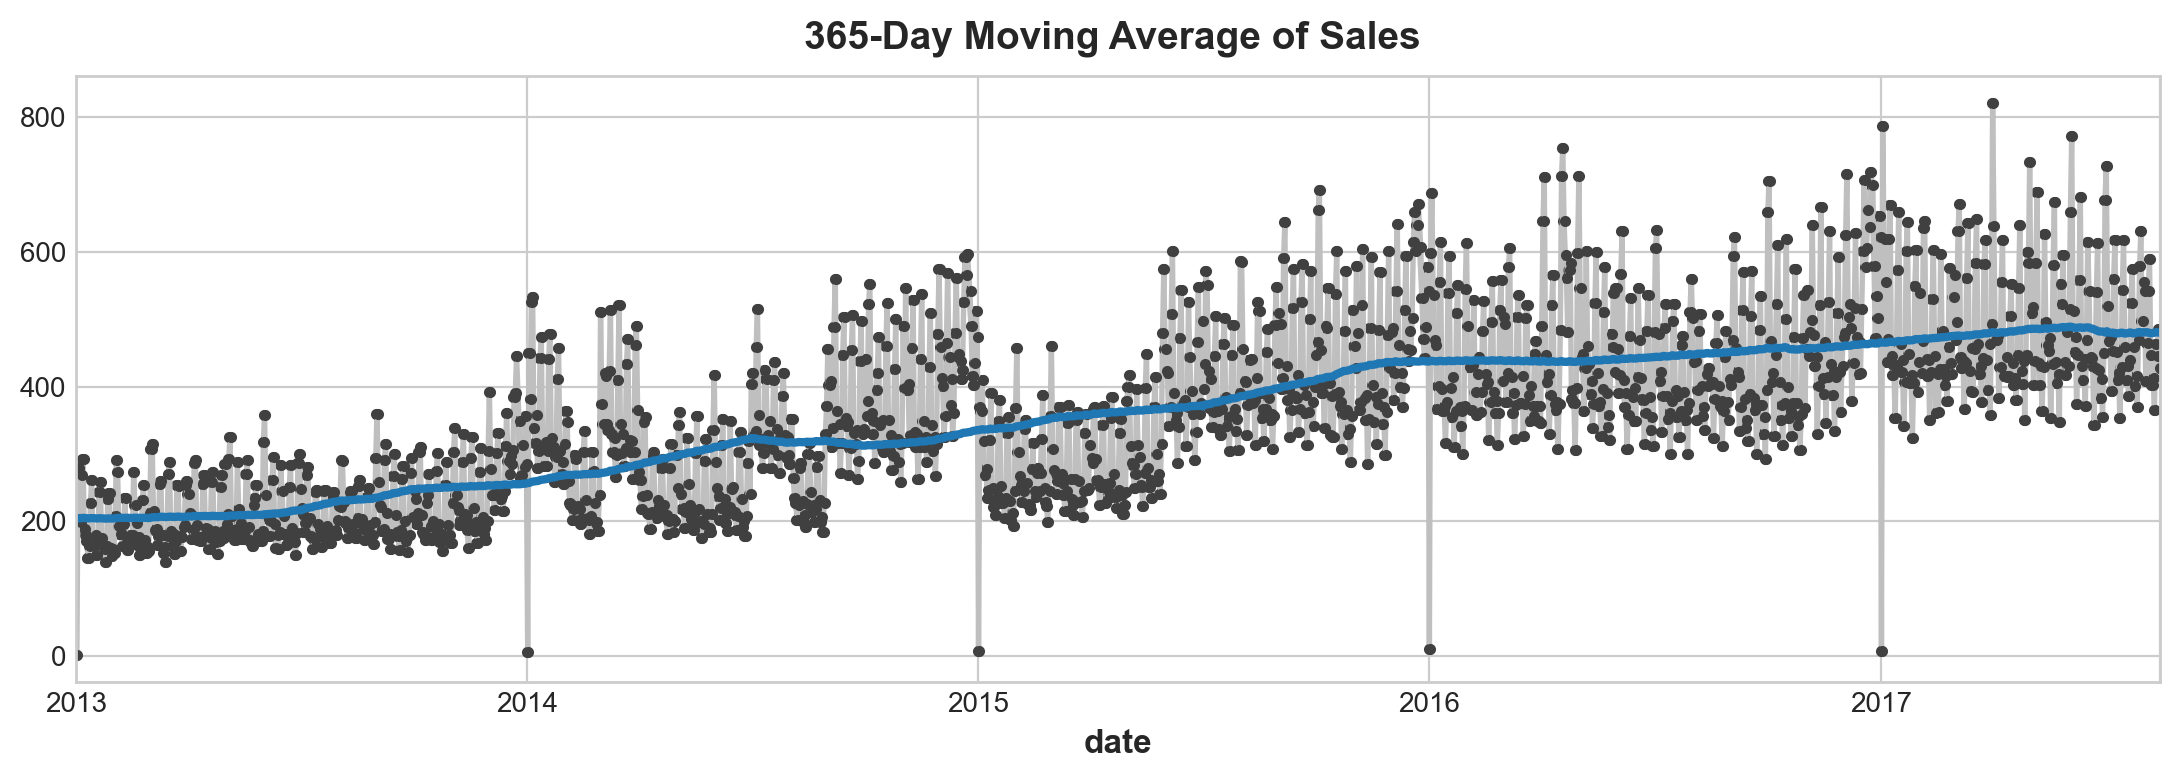

In [276]:
#moving average


moving_average = avg_sales['sales'].rolling(  # using the rolling method to begin a windowed computation
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(**plot_params)
moving_average.plot(
    ax=ax, linewidth=3, title="365-Day Moving Average of Sales ", legend=False)


In [277]:
print(avg_sales.isna().sum().sort_values())

sales    0
lag_1    1
dtype: int64


In [278]:
avg_sales = avg_sales.reindex(columns=['sales'])


In [279]:

# Deterministic Process will help us avoid some tricky failure cases that can arise with time series and linear regression.
from statsmodels.tsa.deterministic import  DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # the time dummy (trend)
    drop=True  # dropping terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()


,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


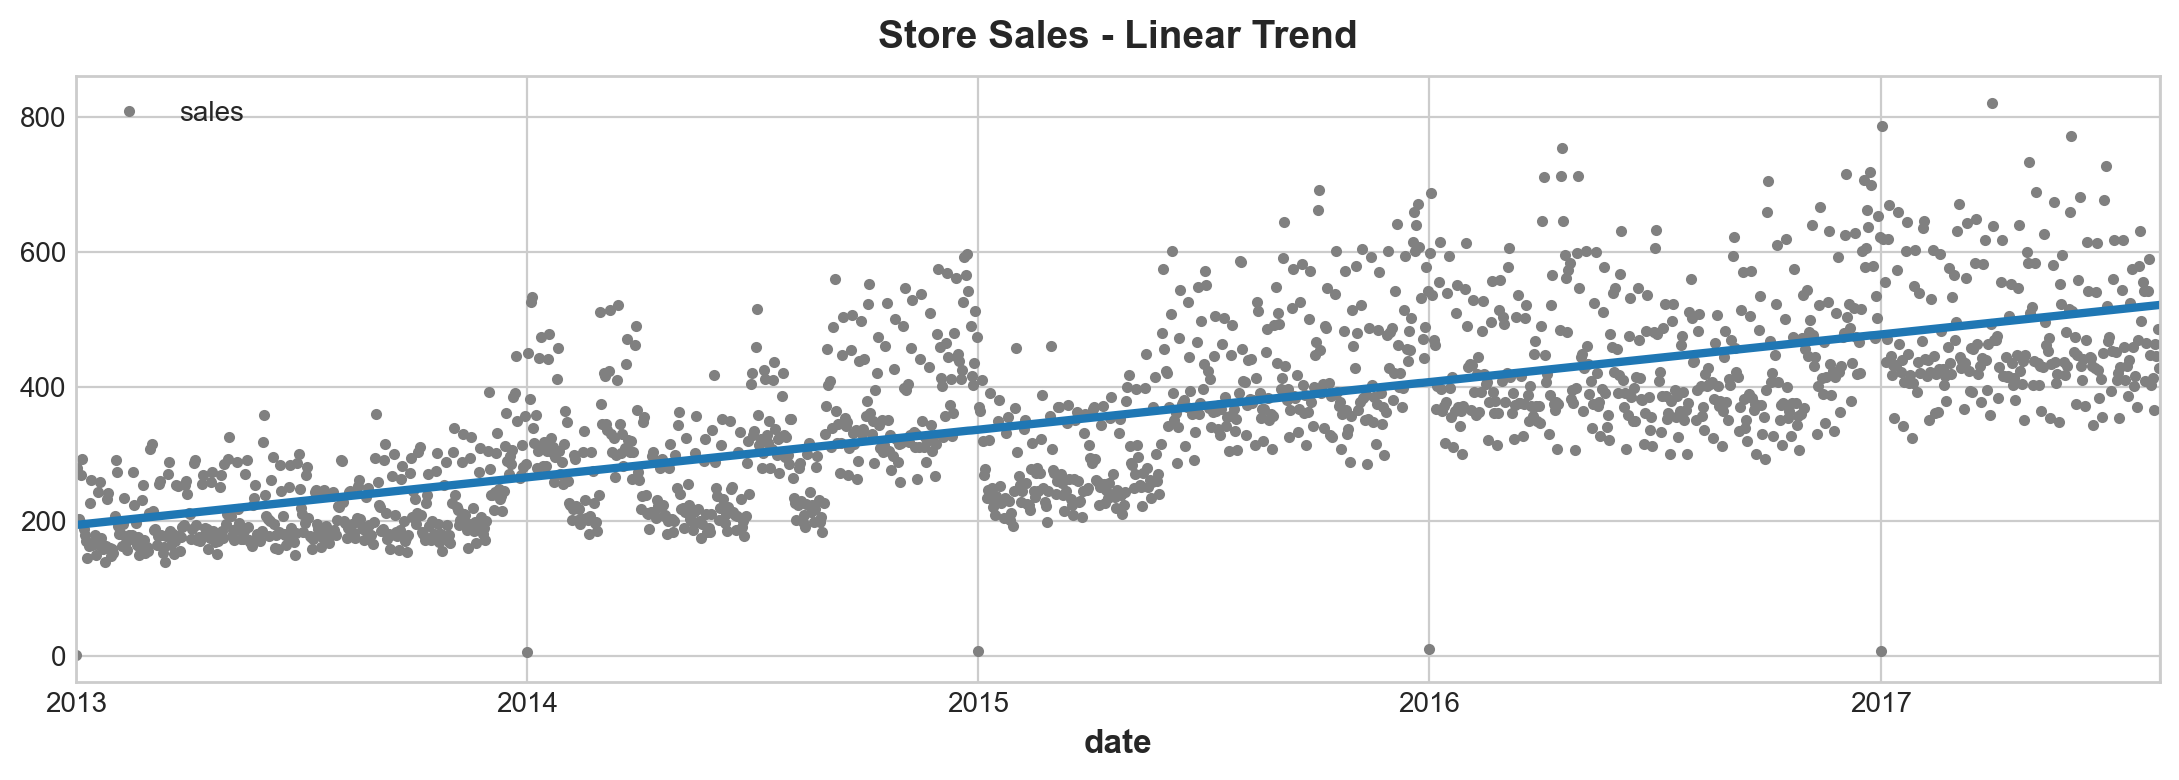

In [280]:
y = avg_sales['sales']  # target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.

lg = LinearRegression(fit_intercept=False)
lg.fit(X, y)

y_pred = pd.Series(lg.predict(X), index=X.index)

ax = avg_sales.plot(style=".", color="0.5", title="Store Sales - Linear Trend")

_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [281]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(lg.predict(X), index=X.index)

y_fore.head()


2017-08-16    521.513055
2017-08-17    521.707402
2017-08-18    521.901749
2017-08-19    522.096096
2017-08-20    522.290443
Freq: D, dtype: float64

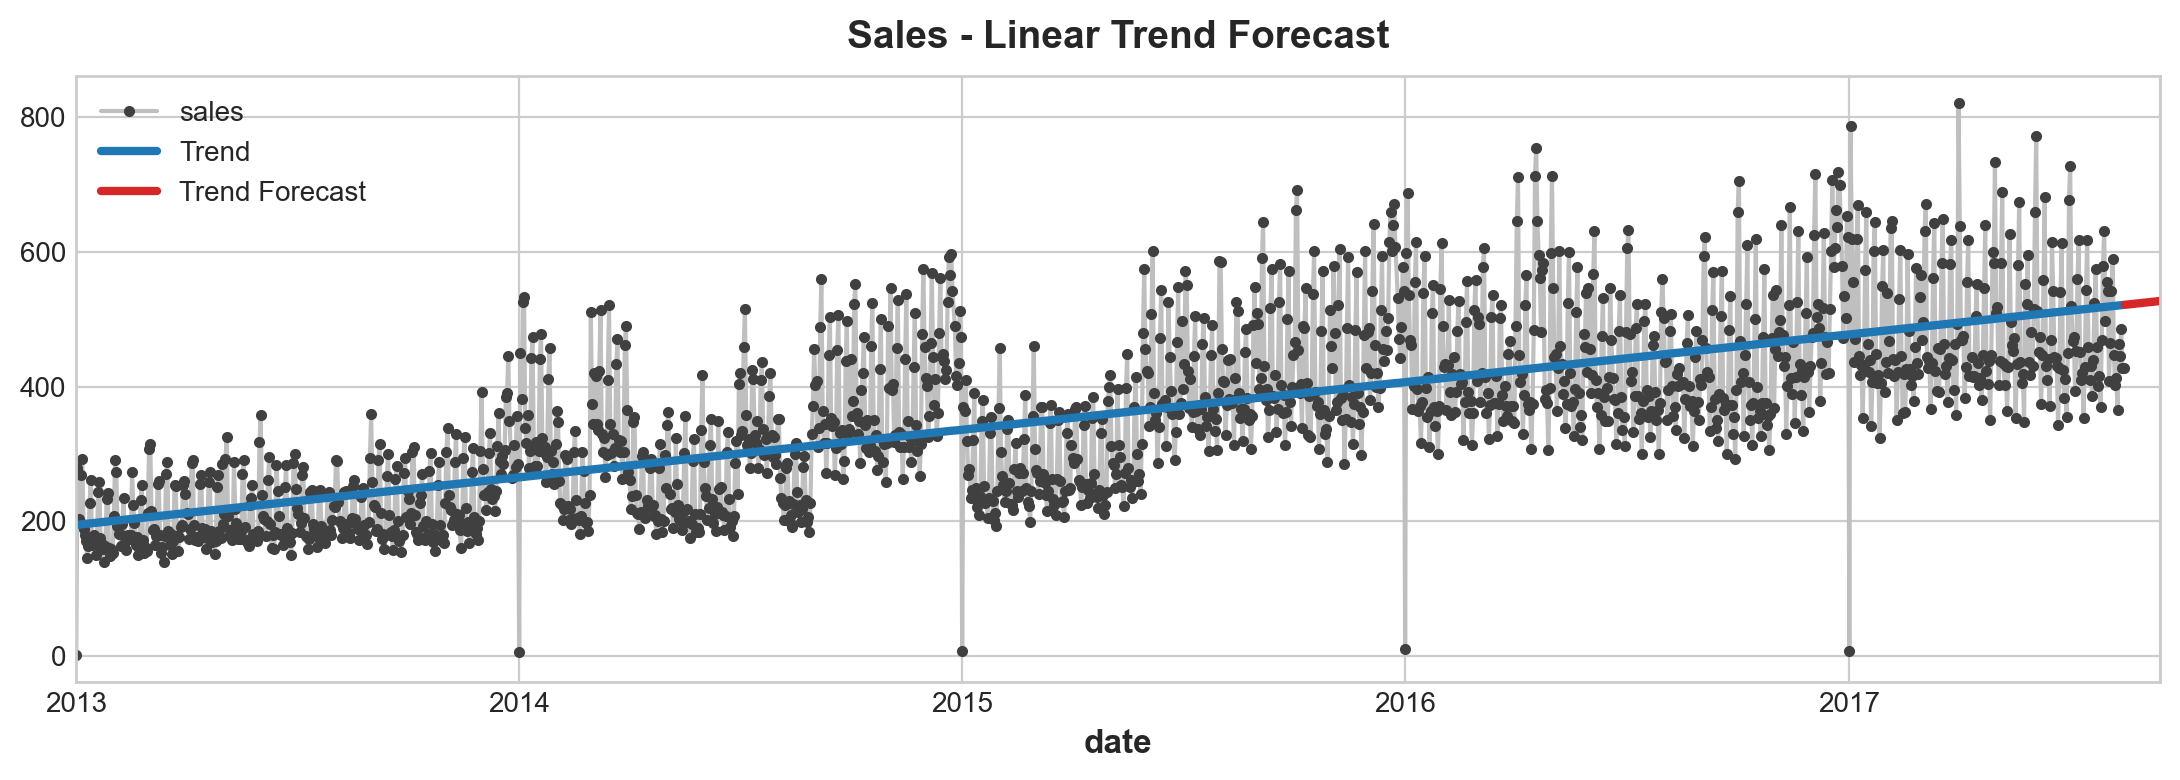

In [282]:
ax = avg_sales["2013-01":].plot(
    title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()


In [283]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

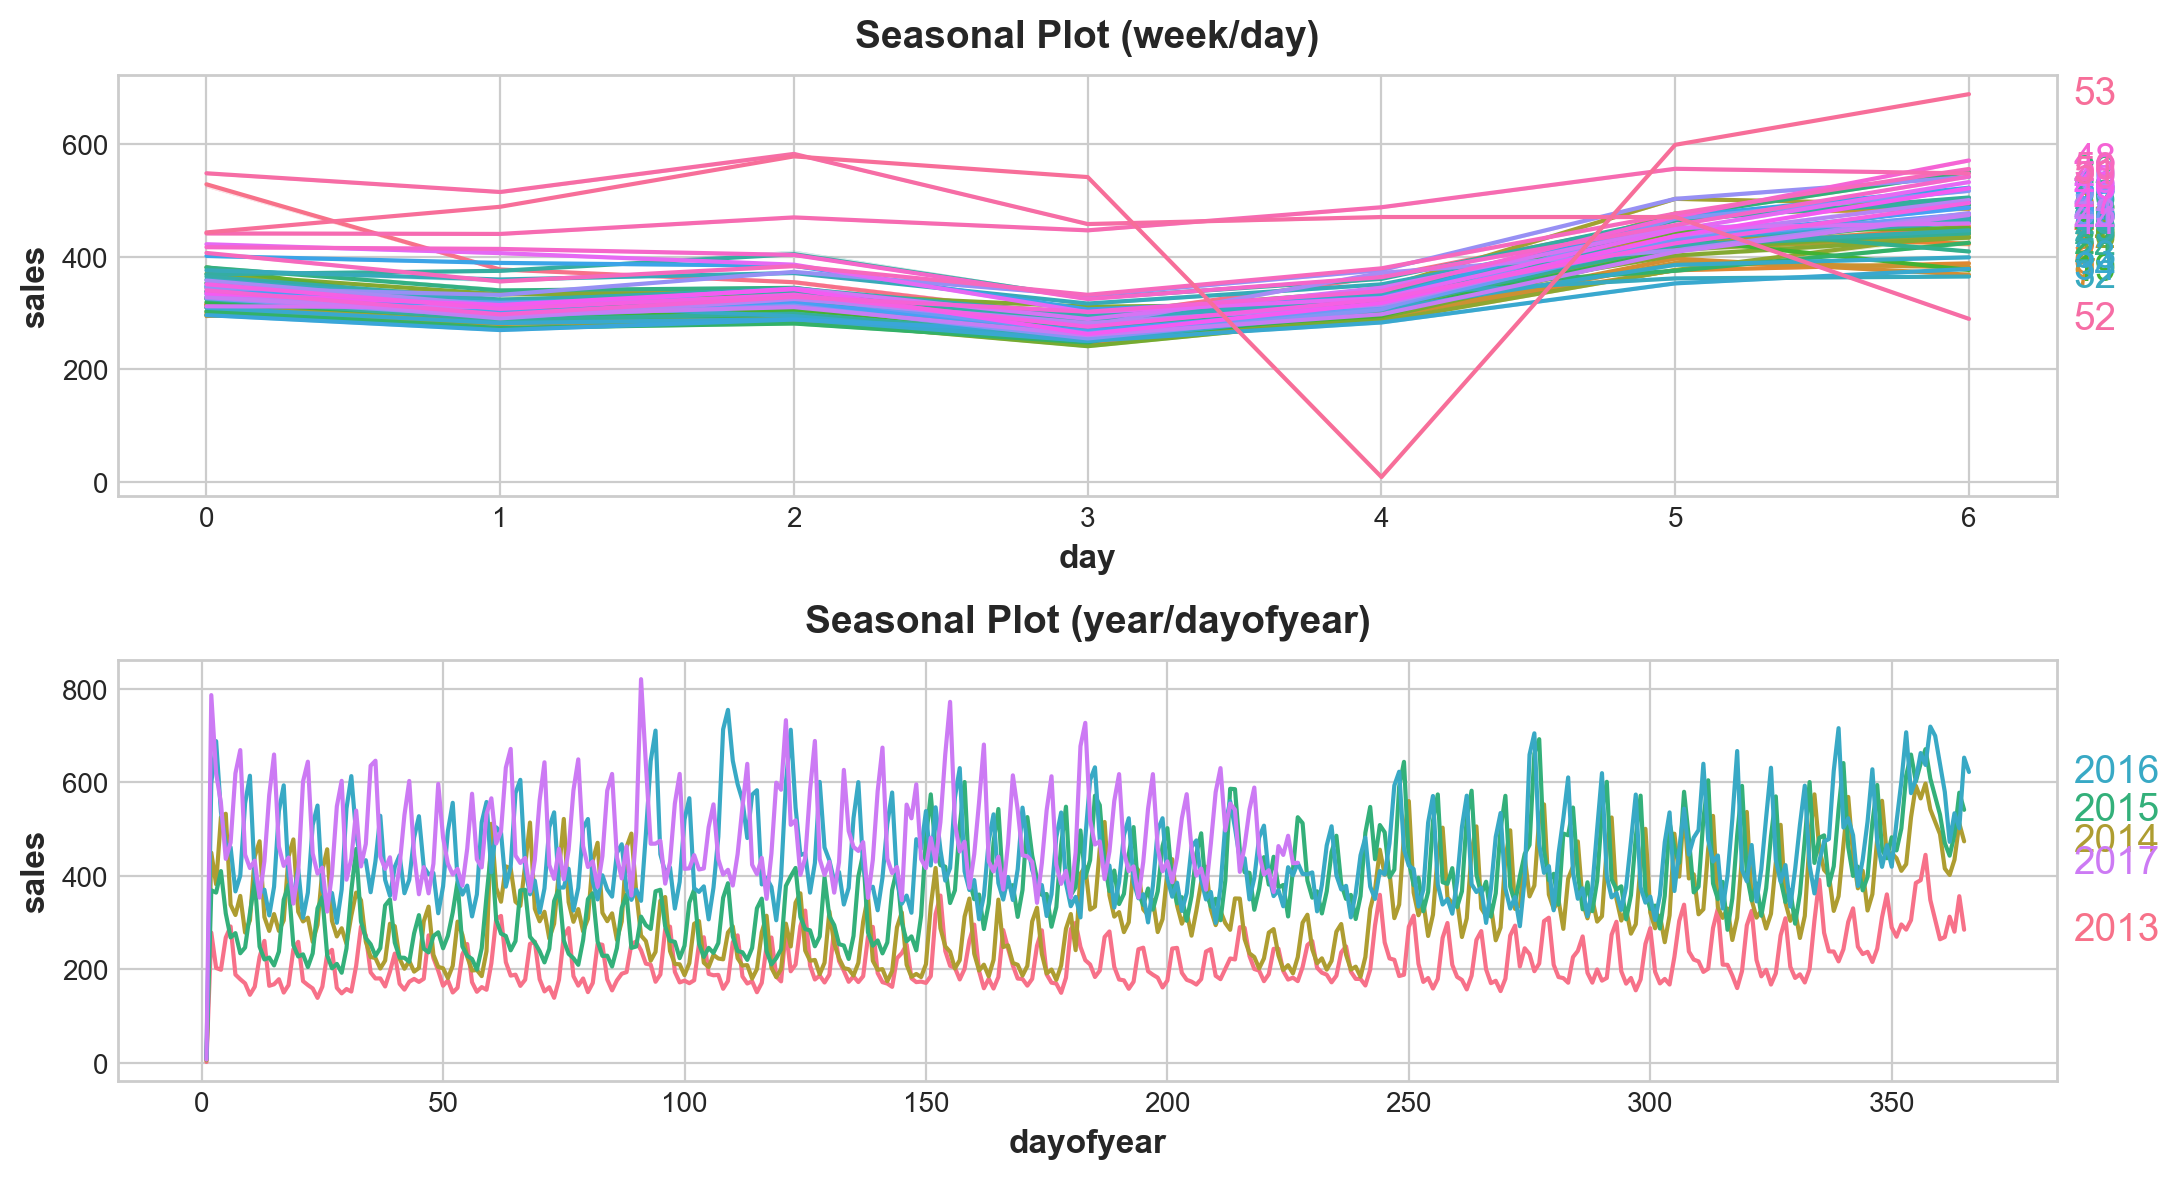

In [294]:
X = avg_sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

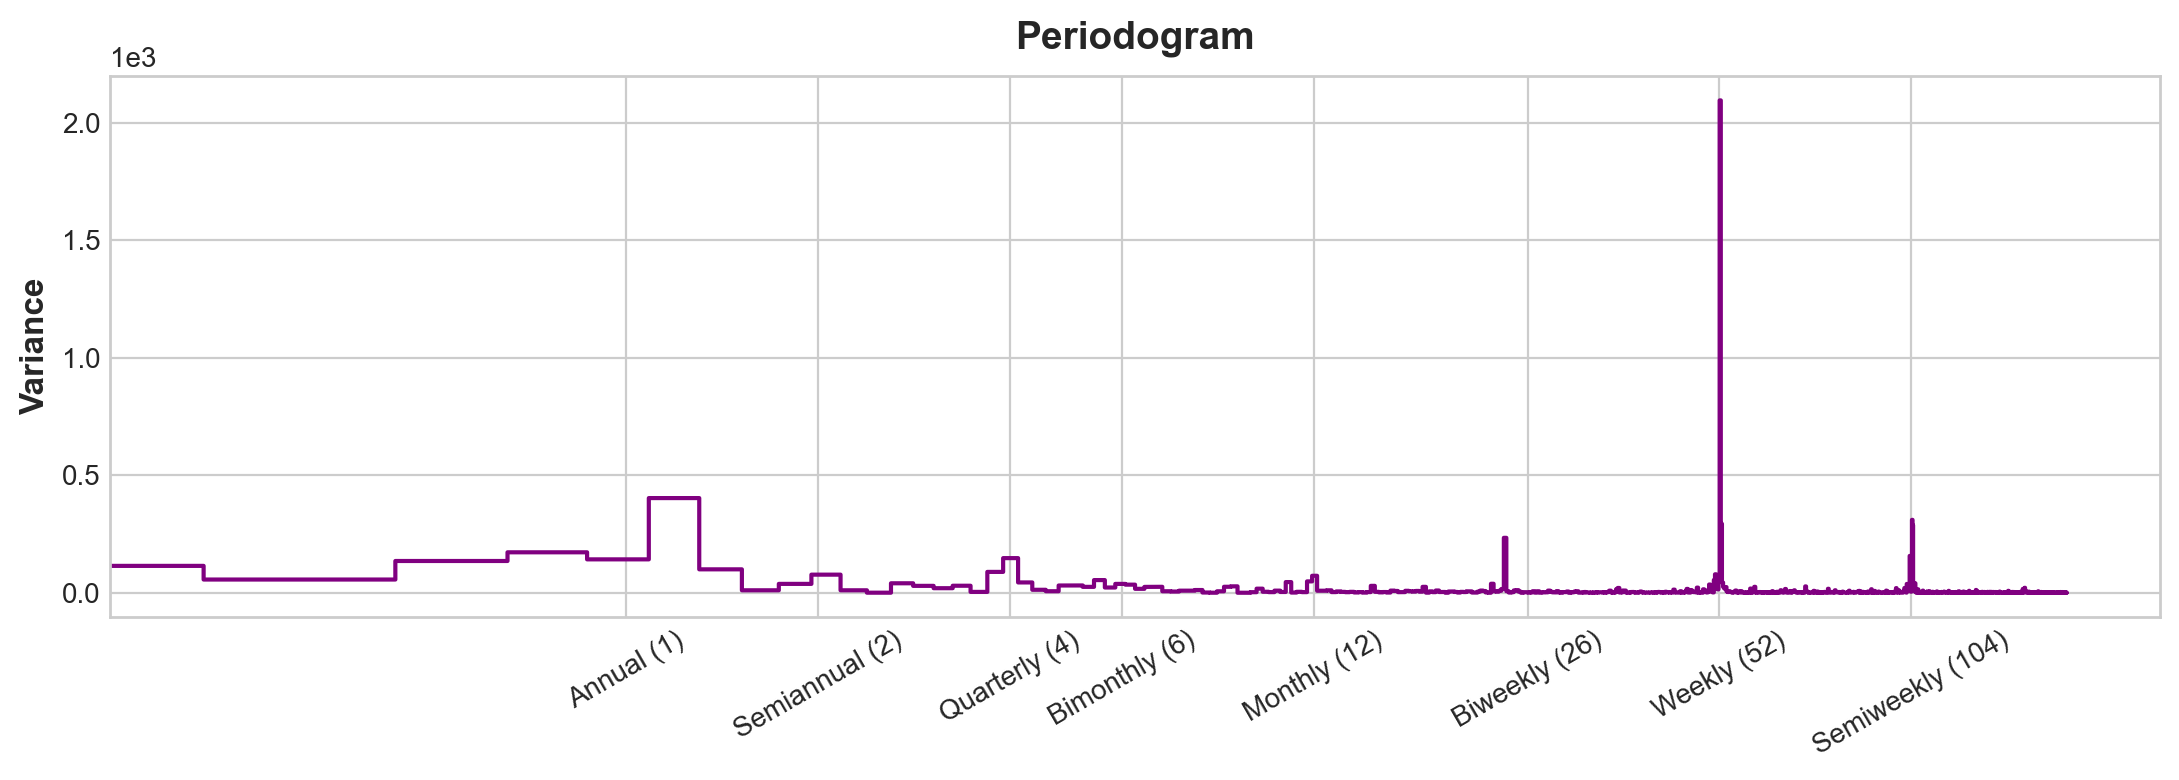

In [295]:
plot_periodogram(avg_sales.sales)
